# To build a time series forecasting model with preprocessed data:

- Set up the window generator to divide consecutive data into inputs and labels
- Transform the timeseries DataFrame into a `tf.data.Dataset`
- Use getter methods
- Compile and train the model
- Conduct the forecasting"

In [1]:
# imports

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
# preprocess data function


def preprocess_data():
    """
    Preprocess the data
    
    Returns:
        tuple: training, testing and validation data
    """
    
    data = pd.read_csv("data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv")
    
    data = data.dropna()
    
    data_lenhth = len(data)
    train_data = data[0:int(data_lenhth * 0.7)]
    valid_data = data[int(data_lenhth * 0.7):int(data_lenhth * 0.9)]
    test_data = data[int(data_lenhth * 0.9):]
    
    # normalizing the data based on training data
    train_mean = train_data.mean()
    train_std = train_data.std()
    train_data = (train_data - train_mean) / train_std
    valid_data = (valid_data - train_mean) / train_std
    test_data = (test_data - train_mean) / train_std
    
    # viualize the data
    plot_features = data["Close"]
    plot_features.index = data["Timestamp"]
    plot_features.plot(subplots=True)
    
    # visualize the preprocessed data
    plot_features = data["Close"]
    plot_features.index = data["Timestamp"]
    plt.plot(plot_features.index, plot_features, label="Projection of Close prices")
    plt.xlabel('Time')
    plt.ylabel('Bitcoin Close value')
    plt.title("Preprocessed Bitcoin Data")
    plt.legend()
    plt.show()
    
    return train_data, valid_data, test_data


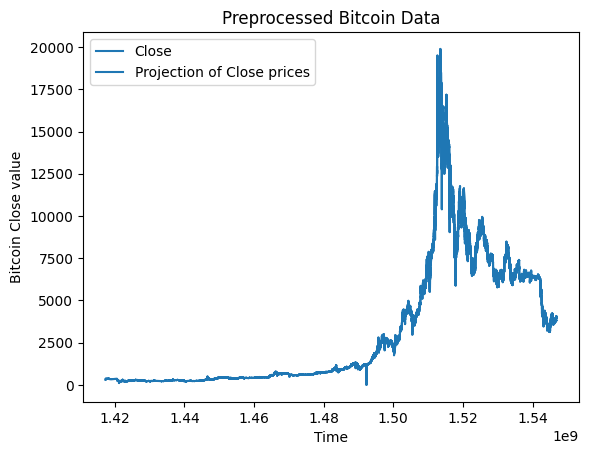

(         Timestamp      Open      High       Low     Close  Volume_(BTC)  \
 0        -1.959813 -0.594395 -0.594450 -0.594326 -0.594397     -0.420441   
 7        -1.959796 -0.594395 -0.594450 -0.594326 -0.594397     -0.420441   
 51       -1.959693 -0.547184 -0.547257 -0.547094 -0.547185     -0.420441   
 77       -1.959632 -0.547184 -0.547257 -0.547094 -0.547185     -0.419404   
 1436     -1.956445 -0.542463 -0.542538 -0.542371 -0.542464     -0.420441   
 ...            ...       ...       ...       ...       ...           ...   
 1500467   1.695717  4.497716  4.495689  4.500007  4.497707     -0.037666   
 1500468   1.695720  4.497716  4.495689  4.500014  4.497707     -0.301579   
 1500469   1.695722  4.497716  4.495689  4.500001  4.497694      0.324191   
 1500470   1.695724  4.497702  4.495682  4.480075  4.487651      1.856946   
 1500471   1.695727  4.487653  4.485637  4.485588  4.487294     -0.044285   
 
          Volume_(Currency)  Weighted_Price  
 0                -0.269688 

In [3]:
preprocess_data()

# The data has been preprocessed.

* Next up is the window generation.

In [4]:
# window generator class

class WindowGenerator:
    """
    Creates windows of consecutive data samples
    """
    def __init__(self, input_width, label_width, shift, train_data,
                 valid_data, test_data, label_columns):
        """
        Class constructor:
        """
        # raw data attributes
        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data
        # column attributes
        self.label_columns = label_columns
        
        # mapping each column name to its correspondent
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        # same thing as above but with the training data
        self.label_columns_indices = {
            name: i for i, name in enumerate(train_data.columns)
        }
        
        # window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        
        # generates an array of indices for the input window
        self.input_indices = np.arange(
            self.total_window_size)[self.input_slice] # the array added assures that it is the same shape as it
        
        # starting label index
        self.label_start = self.total_window_size - self.label_width
        # label slice which represents a range of indices
        self.label_slice = slice(self.label_start, None)
        # generates an array corresponding to the label window
        self.label_indices = np.arange(
            self.total_window_size)[self.label_slice]
            
    def split_window(self, features):
            """
            Converts list of consecutive inputs
            into windows of inputs and labels
            
            Parameters:
                features: list of consecutive input features
            """
            # extract the input and output features from the provided features array
            inputs = features[:, self.input_slice, :]
            labels = features[:, self.label_slice, :]
            
            if self.label_columns is not None:
                # make a new tensor selecting all rows, all time steps
                # and then corresponding index of the desired labels column
                labels = tf.stack(
                    [labels[:, :, self.label_columns_indices[name]] for name in self.label_columns], axis=1
                )
                
            # must set the shapes manually as slicing doesn't preserve static shape info
            inputs.set_shape([None, self.input_width, None])
            labels.set_shape([None, self.label_width, None])
            
            return inputs, labels
    
    def make_dataset(self, data):
        """
        Converts the DataFrame into a tf.data.Dataset
        """
        data = np.array(data, dtype=np.float32)
        dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )
        dataset = dataset.map(self.split_window)
        
        return dataset
    
    # setting up the getters
    @property
    def train(self):
        """
        Returns the training data in tf.data.Dataset format
        """
        return self.make_dataset(self.train_data)
    
    @property
    def val(self):
        """
        Returns the validation data in tf.data.Dataset format
        """
        return self.make_dataset(self.valid_data)
    
    @property
    def test(self):
        """
        Returns the testing data in tf.data.Dataset format
        """
        return self.make_dataset(self.test_data)
    
    @property
    def example(self):
        """
        Gets and caches an example batch of inputs and labels
        for plotting
        """
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        
        return result
    

Now that the model is ready, training starts with the LSTM layer using the window generator.

In [5]:
# Compiles and fits the model

def compile_and_train(model, window, patience=2, epochs=20):
    """
    Compiles and fits the model and returns the history
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.MeanSquaredError(),
        metrics=[tf.metrics.MeanAbsoluteError()]
    )
    
    history = model.fit(
        window.train,
        epochs=epochs,
        validation_data=window.val,
        callbacks=[early_stopping]
    )
    
    return history


With the model prepped, main training begins using the window generator on an LSTM layer.

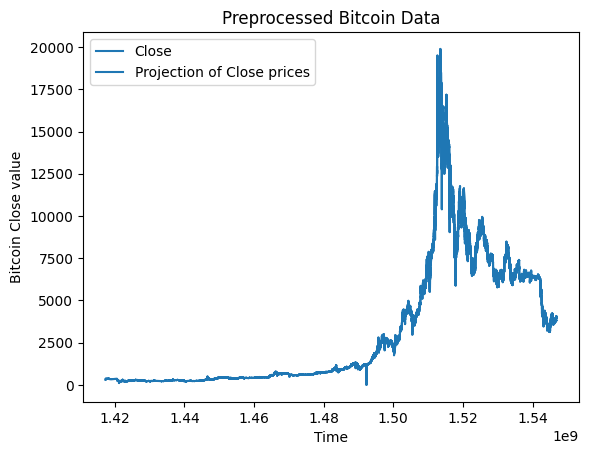

Epoch 1/20
43546/43546 ━━━━━━━━━━━━━━━━━━━━ 175s 4ms/step - loss: 0.9962 - mean_absolute_error: 0.6996 - val_loss: 33.0173 - val_mean_absolute_error: 5.3793
Epoch 2/20
43546/43546 ━━━━━━━━━━━━━━━━━━━━ 179s 4ms/step - loss: 0.9956 - mean_absolute_error: 0.6996 - val_loss: 32.9412 - val_mean_absolute_error: 5.3722
Epoch 3/20
43546/43546 ━━━━━━━━━━━━━━━━━━━━ 170s 4ms/step - loss: 0.9956 - mean_absolute_error: 0.6996 - val_loss: 32.7844 - val_mean_absolute_error: 5.3577
Epoch 4/20
43546/43546 ━━━━━━━━━━━━━━━━━━━━ 167s 4ms/step - loss: 0.9955 - mean_absolute_error: 0.6995 - val_loss: 32.9459 - val_mean_absolute_error: 5.3727
Epoch 5/20
43546/43546 ━━━━━━━━━━━━━━━━━━━━ 138s 3ms/step - loss: 0.9956 - mean_absolute_error: 0.6996 - val_loss: 32.9701 - val_mean_absolute_error: 5.3750
6221/6221 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 8.7530 - mean_absolute_error: 2.8234
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


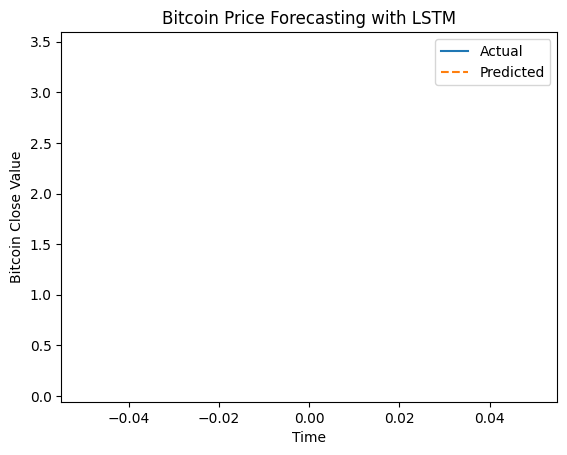

In [6]:
# Main Model

def time_series_forecast(train, valid, test):
    """
    Creates and trains a model to predict future prices of Bitcoin
    
    Parameters:
        train: training data that has been preprocessed
        valid: validation data that has been preprocessed
        test: test data that has been preprocessed
    """
    window = WindowGenerator(
        input_width=24,
        label_width=1,
        shift=1,
        train_data=train,
        valid_data=valid,
        test_data=test,
        label_columns=['Close']
    )
    
    lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(24, return_sequences=False),
        tf.keras.layers.Dense(units=1)
    ])
    
    history = compile_and_train(lstm_model, window)
    
    # making predictions on the test dataset
    test_perfoemance = {}
    test_perfoemance['LSTM'] = lstm_model.evaluate(window.test)
    
    # get the example from test dataset
    inputs, targets = next(iter(window.test))
    
    predictions = lstm_model.predict(inputs)
    
    # plotting
    plt.plot(np.arange(len(targets[0])), targets[0], label='Actual')
    plt.plot(np.arange(len(predictions[0])), predictions[0], label='Predicted', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel('Bitcoin Close Value')
    plt.title('Bitcoin Price Forecasting with LSTM')
    plt.legend()
    plt.show()
    
    return test_perfoemance

if __name__ == '__main__':
    train_data, valid_data, test_data = preprocess_data()
    test_performance = time_series_forecast(train_data, valid_data, test_data)